<a href="https://colab.research.google.com/github/NwaObed/deeplearning/blob/main/Regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2


import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms

import warnings

warnings.filterwarnings('ignore')

In [27]:
from google.colab import drive
#drive.mount('/content/drive')


path = '/content/drive/MyDrive/deeplearning'
images = np.load(path+"/images.npy")#read images
Y = pd.read_csv(path+'/counts.csv')#read cell counts
CV_folds = np.loadtxt(path+'/split.txt')#read fold information

images.shape

(4981, 256, 256, 3)

In [10]:
Y.head()

,neutrophil,epithelial,lymphocyte,plasma,eosinophil,connective
0,0,117,0,0,0,0
1,0,95,1,0,0,8
2,0,172,3,0,0,2
3,0,56,0,0,0,10
4,0,169,7,0,0,0


In [ ]:
CV_folds

array([3., 3., 3., ..., 3., 3., 3.])

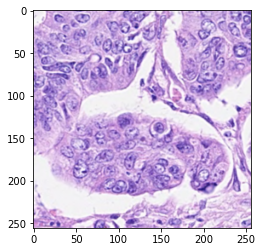

In [ ]:
plt.imshow(images[1,:,:,:])

In [10]:
# Hyper parameters
num_epochs = 5
num_classes = 1
batch_size = 100
learning_rate = 0.00001
weight_decay=0.01

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [28]:
train_img = images[CV_folds==1]
train_img = [transforms.ToTensor()(img) for img in train_img]
train_img = list(zip(train_img, Y['lymphocyte'][CV_folds==1]))

validate_img = images[CV_folds==2]
validate_img = [transforms.ToTensor()(img) for img in validate_img]
validate_img = list(zip(validate_img, Y['lymphocyte'][CV_folds==2]))

test_img = images[CV_folds==3]
test_img = [transforms.ToTensor()(img) for img in test_img]
test_img = list(zip(test_img, Y['lymphocyte'][CV_folds==3]))


# Load data
trainloader = torch.utils.data.DataLoader(train_img,
                                         batch_size=batch_size,
                                         num_workers=4,
                                         shuffle=True)

validate_loader = torch.utils.data.DataLoader(validate_img,
                                             #batch_size=batch_size,
                                             num_workers=4,
                                             shuffle=False)

test_loader = torch.utils.data.DataLoader(test_img,
                                         batch_size=batch_size,
                                         num_workers=4,
                                         shuffle=False)

In [9]:
class RegNet(nn.Module):
    
    def __init__(self):
        super(RegNet, self).__init__()
        
        self.features = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=4),
                                     nn.BatchNorm2d(16),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2,2),
                                     
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2,2),
                                     
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(inplace=True),
                                     
                                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(inplace=True),
                                     nn.AvgPool2d(2,2),
                                     
                                     nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, stride=1, padding=1),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2,2))
        
        self.regress = nn.Sequential(nn.Linear(16*16*512, 1024),
                                       nn.Linear(1024, 2048),
                                       nn.Linear(2048,1))
        
    def forward(self,out):
        out = self.features(out)
        
        #flatten into a single vector
        out = out.view(-1, 512*16*16)
        
        out = self.regress(out)
        
        return out
    
regModel = RegNet().to(device)

#Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(regModel.parameters(),
                             lr=learning_rate, 
                             weight_decay=weight_decay)


In [37]:
#Train

regModel.train()
total_step = len(trainloader)

for epoch in range(num_epochs):
    losses = []
    for i, (input_data,count) in enumerate(trainloader, 0):
        
        input_data = input_data.to(device)
        count = count.to(device).to(torch.float32)
        
        output = regModel(input_data)
        loss = criterion(output, count)
        losses.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        


In [36]:
#Validation

regModel.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
Count_pred = []

with torch.no_grad():
#     correct = 0
#     total = 0
    for i, (images, counts) in enumerate(validate_loader, 0):
        
        images = images.to(device)
        counts = counts.to(device).to(torch.float32)
        outputs = regModel(images)
        
        Count_pred.append(outputs.cpu().numpy())


Y_val=Y['lymphocyte'][CV_folds==2]
Y_prd = np.array([count[:,0][0]for count in Count_pred])
#stats.pearsonr(Ytt,c)[0]

print(Y_val.shape)
print(Y_prd.shape)

pcc = round(stats.pearsonr(Y_val,Y_prd)[0],4)#pearson
scc = round(stats.spearmanr(Y_val,Y_prd)[0],4)#spearman
rsme = round(MSE(Y_val,Y_prd,squared=False),4)#RSME
r2 = round(R2(Y_val,Y_prd), 4)#R2

df = pd.DataFrame({
    'Metric Value':[pcc,scc,rsme,r2]
},index=['Pearson CC','Spearman CC','RMSE','R2'])
df

(1751,)
(1751,)


,Metric Value
Pearson CC,-0.0308
Spearman CC,0.1399
RMSE,32.9906
R2,-0.0027


# Helper functions


In [ ]:
def npy_loader(path):
    return torch.from_numpy(np.load(path))




In [ ]:
npy_dir = '/home/nwachukwu/CS909/CS909/2022/u2126600_assignment2/'
transform = transforms.Compose(transforms.ToTensor())

trainset = torchvision.datasets.DatasetFolder(root = npy_dir,
                                             loader=npy_loader,
                                             extensions=['.npy'],
                                             transform=transform)
